# Optimal Portfolio Allocation

### Selection of Stock and Risk Aversion(Risk Seeking: A<0; Risk Averse: A>0)

In [1]:
# Fetch multiple stocks at once
stock_list = ["NVDA", "AAPL", "MSFT","COST","TSLA","AMZN","INTC","BTC","BA"]
# Risk aversion
A = 0.01

## Data Processing

### Import

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, kurtosis, skew
import warnings
from scipy.stats import norm
import scipy.linalg as la
from matplotlib.widgets import Slider
import sys
from PyQt5.QtWidgets import (QApplication, QMainWindow, QVBoxLayout, QHBoxLayout, 
                            QWidget, QLabel, QDoubleSpinBox, QPushButton, QGroupBox, QSlider)
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.figure import Figure
from PyQt5.QtCore import Qt
import sys
import numpy as np
from scipy.stats import norm
from PyQt5.QtWidgets import *
from PyQt5.QtCore import Qt
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.figure import Figure

### Fetch stock historical data from yahoo finance

In [3]:
# Download historical data for all stocks
data = yf.download(stock_list, start="2024-01-01", interval="1d")

# Extract close prices
close_prices = data['Close']

# Calculate daily returns (percentage change)
daily_returns = close_prices.pct_change()  # Convert to percentage

# Remove the first row (NaN values from pct_change)
daily_returns = daily_returns.dropna()
# Annualize
daily_returns = 252 * np.log(1 + daily_returns)

# Calculate mean returns and convert to NumPy array
mean_returns = daily_returns.mean()
mean_np = mean_returns.to_numpy()

# Calculate covariance matrix
covariance_matrix = daily_returns.cov()
cov_np = covariance_matrix.to_numpy()  # Convert to NumPy array

# Calculate correlation matrix
correlation_matrix = daily_returns.corr()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11884\701291279.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(stock_list, start="2024-01-01", interval="1d")
[*********************100%***********************]  9 of 9 completed
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11884\701291279.py:8: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_returns = close_prices.pct_change()  # Convert to percentage


## Display Stock Information

### Daily close price (%)

In [4]:
close_prices.tail()

Ticker,AAPL,AMZN,BA,BTC,COST,INTC,MSFT,NVDA,TSLA
Date,,,,,,,,,
2025-08-26,229.309998,228.710007,234.830002,49.220001,941.340027,24.35,502.040009,181.770004,351.670013
2025-08-27,230.490005,229.119995,235.619995,49.669998,949.520020,24.85,506.739990,181.600006,349.600006
2025-08-28,232.559998,231.600006,236.160004,49.580002,944.960022,24.93,509.640015,180.169998,345.980011
2025-08-29,232.139999,229.000000,234.679993,47.930000,943.320007,24.35,506.690002,174.179993,333.869995
2025-09-02,NaN,NaN,NaN,49.145000,938.690002,NaN,NaN,NaN,NaN


### Daily Returns (%)

In [5]:
daily_returns.tail()

Ticker,AAPL,AMZN,BA,BTC,COST,INTC,MSFT,NVDA,TSLA
Date,,,,,,,,,
2025-08-26,2.373880,0.849847,8.690147,0.769161,-0.064238,-2.061349,-1.111878,2.732046,3.659514
2025-08-27,1.293443,0.451334,0.846332,2.293458,2.180353,5.122127,2.348191,-0.235790,-1.487710
2025-08-28,2.253068,2.713009,0.576888,-0.457009,-1.213126,0.809964,1.438061,-1.992226,-2.622982
2025-08-29,-0.455518,-2.845022,-1.584249,-8.529178,-0.437736,-5.932091,-1.462921,-8.520532,-8.978589
2025-09-02,0.000000,0.000000,0.000000,6.308442,-1.239912,0.000000,0.000000,0.000000,0.000000


### Summary Statistics for Daily Returns (%):

In [6]:
daily_returns.describe()

Ticker,AAPL,AMZN,BA,BTC,COST,INTC,MSFT,NVDA,TSLA
count,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000
mean,0.046419,0.187814,0.192748,0.490293,0.127727,-0.210039,0.186092,0.368791,0.336969
std,4.954616,5.459175,6.057746,7.840288,3.433999,10.353766,3.855129,8.374857,11.010764
min,-24.447353,-23.708502,-27.873241,-39.678273,-15.778805,-76.077828,-16.078028,-46.858420,-42.221527
25%,-1.724247,-2.314810,-2.779633,-3.939525,-1.619595,-5.640810,-1.505620,-3.509007,-5.748642
50%,0.295106,0.131729,0.396385,0.270008,0.071859,-0.462940,0.283841,0.862028,-0.108762
75%,2.362604,3.251981,3.443929,5.256602,2.025573,4.639768,2.031097,5.123200,7.157741
max,35.939586,28.507144,36.038524,32.302945,15.184246,43.313600,24.324243,43.248392,51.531626


### Daily Returns Covariance Matrix:

In [7]:
covariance_matrix

Ticker,AAPL,AMZN,BA,BTC,COST,INTC,MSFT,NVDA,TSLA
Ticker,,,,,,,,,
AAPL,24.548215,15.613979,13.751226,11.471260,7.035269,15.874016,10.292704,18.107054,26.171156
AMZN,15.613979,29.802595,16.262727,14.804182,6.062885,26.598181,14.400167,25.785980,31.265464
BA,13.751226,16.262727,36.696283,12.351342,7.031276,23.112763,8.557368,21.379891,29.097069
BTC,11.471260,14.804182,12.351342,61.470117,6.576743,13.557792,10.116730,22.571086,41.915392
COST,7.035269,6.062885,7.031276,6.576743,11.792346,5.987363,4.981353,6.756115,14.454060
INTC,15.874016,26.598181,23.112763,13.557792,5.987363,107.200460,14.131019,32.229382,38.523292
MSFT,10.292704,14.400167,8.557368,10.116730,4.981353,14.131019,14.862016,20.050573,19.465936
NVDA,18.107054,25.785980,21.379891,22.571086,6.756115,32.229382,20.050573,70.138234,43.295908
TSLA,26.171156,31.265464,29.097069,41.915392,14.454060,38.523292,19.465936,43.295908,121.236913


### Daily Returns Correlation Matrix:

In [8]:
correlation_matrix

Ticker,AAPL,AMZN,BA,BTC,COST,INTC,MSFT,NVDA,TSLA
Ticker,,,,,,,,,
AAPL,1.000000,0.577267,0.458163,0.295304,0.413495,0.309441,0.538866,0.436376,0.479728
AMZN,0.577267,1.000000,0.491762,0.345880,0.323409,0.470573,0.684229,0.564000,0.520140
BA,0.458163,0.491762,1.000000,0.260059,0.338005,0.368504,0.366429,0.421422,0.436235
BTC,0.295304,0.345880,0.260059,1.000000,0.244275,0.167016,0.334710,0.343750,0.485539
COST,0.413495,0.323409,0.338005,0.244275,1.000000,0.168398,0.376278,0.234920,0.382272
INTC,0.309441,0.470573,0.368504,0.167016,0.168398,1.000000,0.354027,0.371686,0.337915
MSFT,0.538866,0.684229,0.366429,0.334710,0.376278,0.354027,1.000000,0.621027,0.458584
NVDA,0.436376,0.564000,0.421422,0.343750,0.234920,0.371686,0.621027,1.000000,0.469518
TSLA,0.479728,0.520140,0.436235,0.485539,0.382272,0.337915,0.458584,0.469518,1.000000


### Distribution of Daily Return of Each Stock

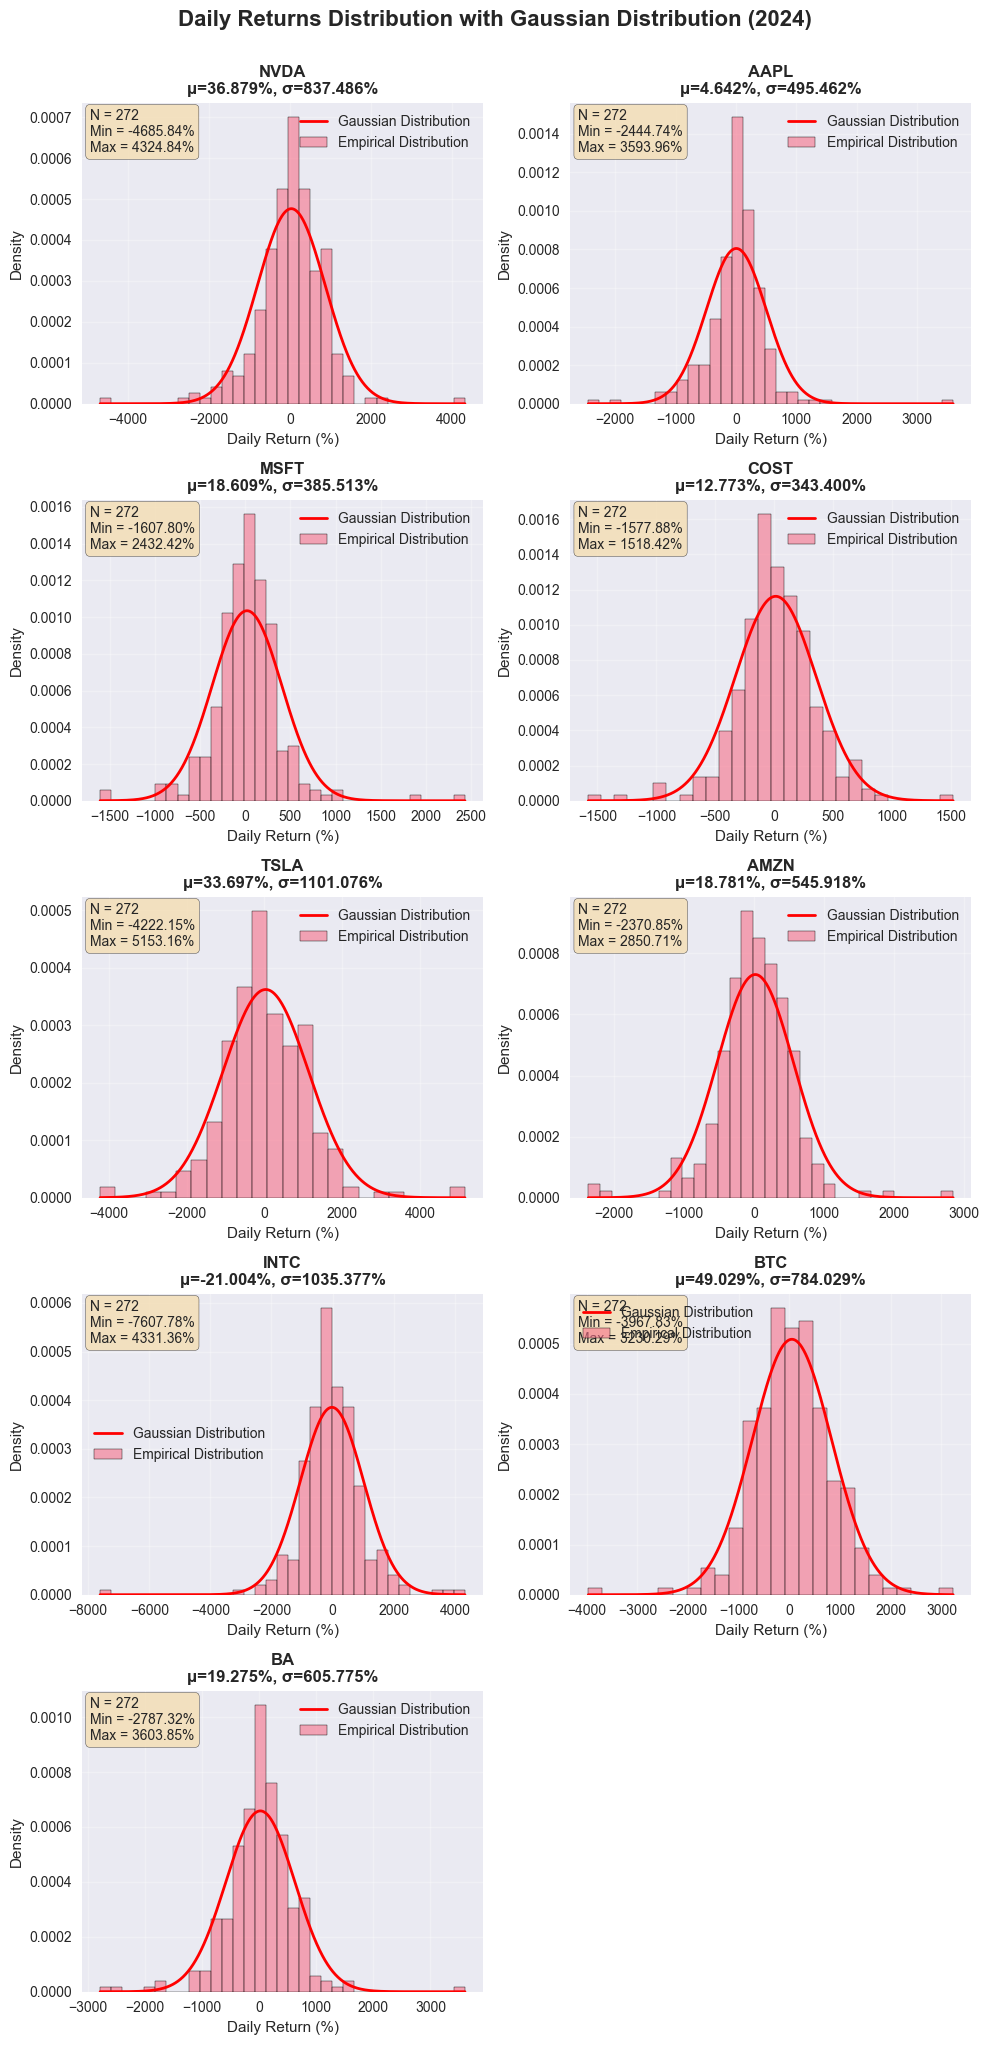

In [9]:
warnings.filterwarnings('ignore')
# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Calculate the optimal grid size
n_stocks = len(stock_list)
n_cols = 2  # You can adjust this
n_rows = (n_stocks + n_cols - 1) // n_cols  # Ceiling division

# Create subplots with dynamic grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()  # Flatten to 1D array for easy iteration

# Plot individual stock distributions
for i, stock in enumerate(stock_list):
    returns = daily_returns[stock].dropna()
    
    # Calculate statistics
    mu = returns.mean() * 100  # Convert to percentage for display
    std = returns.std() * 100   # Convert to percentage for display
    n_observations = len(returns)
    
    # Plot histogram with KDE
    sns.histplot(returns * 100, stat='density', alpha=0.6, 
                 label='Empirical Distribution', ax=axes[i])
    
    # Generate Gaussian distribution using calculated mean and std
    x = np.linspace(returns.min() * 100, returns.max() * 100, 1000)
    gaussian = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / std) ** 2)
    
    # Plot Gaussian distribution
    axes[i].plot(x, gaussian, 'r-', linewidth=2, label='Gaussian Distribution')
    
    # Customize plot
    axes[i].set_title(f'{stock}\n'
                     f'μ={mu:.3f}%, σ={std:.3f}%',
                     fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Daily Return (%)')
    axes[i].set_ylabel('Density')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
    
    # Add text box with statistics
    textstr = f'N = {n_observations}\nMin = {returns.min()*100:.2f}%\nMax = {returns.max()*100:.2f}%'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    axes[i].text(0.02, 0.98, textstr, transform=axes[i].transAxes, fontsize=10,
                verticalalignment='top', bbox=props)

# Remove any empty subplots
for i in range(len(stock_list), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.suptitle('Daily Returns Distribution with Gaussian Distribution (2024)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

## Machine Learning Seeking Optimal Portfolio

In [10]:
def cal_mean_var(weights, mean_np, cov_np): 
    portfolio_return = weights.T @ mean_np
    portfolio_variance = weights.T @ (cov_np @ weights)
    return portfolio_return, portfolio_variance

def cal_util(mu,var,A):
    return mu - 0.5*A*var

### Machine Learning Algorithms

In [ ]:
def GD(w, mean_np, cov_np, learning_rate=0.000001, max_iterations=1000000):
    util_list = np.zeros(max_iterations)  # Pre-allocate
    finish_i = max_iterations - 1  # Default if we complete all iterations
    
    for i in range(max_iterations):
        cur_mu, cur_var = cal_mean_var(w, mean_np, cov_np)

        # Calculate gradient: A * COV @ w - MEAN
        gradient = A * (cov_np @ w) - mean_np
        # Update weights
        w_new = w - learning_rate * gradient
        
        # Project onto constraint: weights sum to 1
        w_new = w_new / np.sum(w_new)
        
        new_mu, new_var = cal_mean_var(w_new, mean_np, cov_np)
        new_util = cal_util(new_mu, new_var, A)
        
        # Store utility value
        util_list[i] = new_util
        
        # Check if converged (utility decreases)
        if (new_util - cal_util(cur_mu, cur_var, A)) < 1e-9:
            finish_i = i
            break
            
        w = w_new

    # Return only the relevant portion of util_list
    return w, finish_i, util_list[:finish_i+1]

def ADAM(w, mean_np, cov_np, learning_rate=0.001, max_iterations=1000000, beta1=0.9, beta2=0.999, epsilon=1e-8):
    util_list = np.zeros(max_iterations)  # Pre-allocate
    finish_i = max_iterations - 1  # Default if we complete all iterations
    
    # Adam initialization
    m = np.zeros_like(w)  # First moment vector
    v = np.zeros_like(w)  # Second moment vector
    t = 0  # Time step
    
    for i in range(max_iterations):
        t += 1
        cur_mu, cur_var = cal_mean_var(w, mean_np, cov_np)

        # Calculate gradient: A * COV @ w - MEAN
        gradient = A * (cov_np @ w) - mean_np
        
        # Adam update
        m = beta1 * m + (1 - beta1) * gradient
        v = beta2 * v + (1 - beta2) * (gradient ** 2)
        
        # Bias correction
        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)
        
        # Update weights
        w_new = w - learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)
        
        # Project onto constraint: weights sum to 1
        w_new = w_new / np.sum(w_new)
        
        new_mu, new_var = cal_mean_var(w_new, mean_np, cov_np)
        new_util = cal_util(new_mu, new_var, A)
        
        # Store utility value
        util_list[i] = new_util
        
        # Check if converged (utility decreases)
        if (new_util - cal_util(cur_mu, cur_var, A)) < 1e-9:
            finish_i = i
            break
            
        w = w_new

    return w, util_list, finish_i

def closed_form(A, mean_np, cov_np):
    if np.linalg.det(covariance_matrix) == 0:
        # Use pseudo-inverse if matrix is singular
        cov_inv = np.linalg.pinv(covariance_matrix)
    else:
        cov_inv = np.linalg.inv(covariance_matrix)

    w_opt = (1 / A) * cov_inv @ mean_np
    w_opt = w_opt / np.sum(w_opt)
    portfolio_return, portfolio_variance = cal_mean_var(w_opt, mean_np, cov_np)
    util = cal_util(portfolio_return,portfolio_variance,A)
    return w_opt, 1, np.array([util])

### Optimazation

#### GD

In [ ]:
w = np.array([1/len(stock_list)] * len(stock_list))
w, finish_i, util_list = GD(w, mean_np,cov_np, learning_rate = 0.000001, max_iterations = 10000000)

#### Closed-Form

In [13]:
w, finish_i, util_list = closed_form(A, mean_np,cov_np)

## Machine Learning Outcome

### Learning curve and optimal portfolio distribution

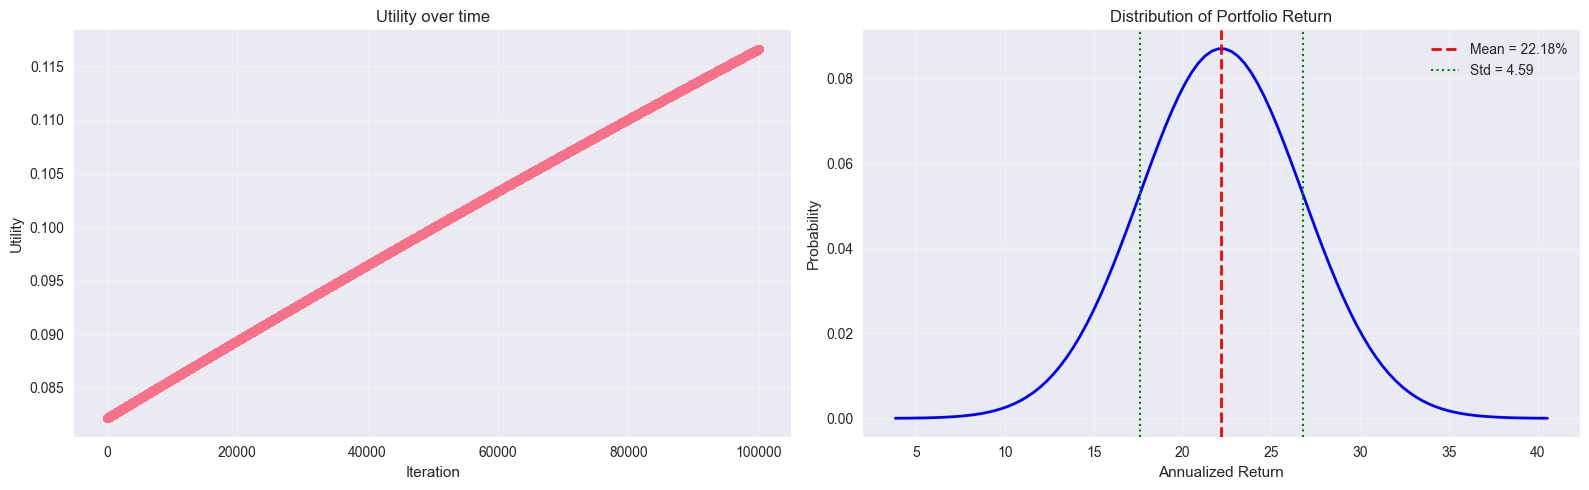

In [19]:
portfolio_return, portfolio_variance = cal_mean_var(w, mean_np, cov_np)
utility = cal_util(portfolio_return,portfolio_variance,A)
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# First plot: Utility List
ax1.plot(util_list, marker='o', linestyle='-', linewidth=2, markersize=6)
ax1.set_title('Utility over time')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Utility')
ax1.grid(True, alpha=0.3)

# Second plot: Gaussian Distribution
mean = portfolio_return*100
std = np.sqrt(portfolio_variance)
x_range = (mean - 4*std, mean + 4*std)
x = np.linspace(x_range[0], x_range[1], 100)
y = (1/(std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean)/std)**2)

ax2.plot(x, y, 'b-', linewidth=2)
ax2.axvline(mean, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean:.2f}%')
ax2.axvline(mean + std, color='green', linestyle=':', linewidth=1.5, label=f'Std = {std:.2f}')
ax2.axvline(mean - std, color='green', linestyle=':', linewidth=1.5)
ax2.set_title(f'Distribution of Portfolio Return')
ax2.set_xlabel('Annualized Return')
ax2.set_ylabel('Probability')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

### Summary of Portfolio

PORTFOLIO ANALYSIS
# of Long Positions:             9
# of Short Positions:            0
Max Allocation:              14.1%
Min Allocation:               6.3%
Utility:                      0.12

DETAILED BREAKDOWN:
--------------------------------------------------
  COST:    14.1% (LONG)
   BTC:    12.2% (LONG)
  INTC:    11.9% (LONG)
  TSLA:    11.9% (LONG)
  MSFT:    11.4% (LONG)
  AAPL:    11.3% (LONG)
    BA:    10.7% (LONG)
  NVDA:    10.2% (LONG)
  AMZN:     6.3% (LONG)


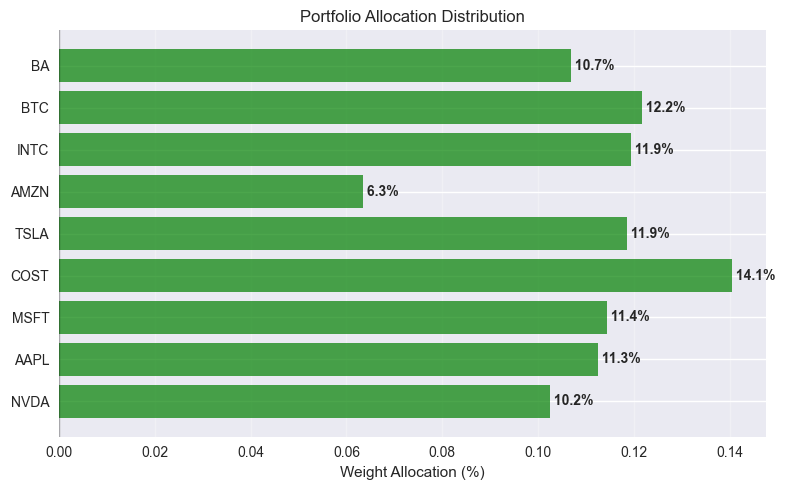

In [20]:
# Sample data (replace with your actual data)
positive_weights = [w for w in w if w > 0]
negative_weights = [w for w in w if w < 0]

print("PORTFOLIO ANALYSIS")
print("=" * 50)
print(f"{'# of Long Positions:':<25} {len(positive_weights):>8}")
print(f"{'# of Short Positions:':<25} {len(negative_weights):>8}")
print(f"{'Max Allocation:':<25} {max(w):>8.1%}")
print(f"{'Min Allocation:':<25} {min(w):>8.1%}")
print(f"{'Utility:':<25} {utility:>8.2f}")
print("\nDETAILED BREAKDOWN:")
print("-" * 50)

# Sort by absolute weight (descending)
sorted_data = sorted(zip(stock_list, w), key=lambda x: abs(x[1]), reverse=True)

for stock, weight in sorted_data:
    position_type = "LONG" if weight > 0 else "SHORT"
    print(f"{stock:>6}: {weight:>8.1%} ({position_type})")

# Create bar graph
plt.figure(figsize=(8, 5))
colors = ['green' if weight > 0 else 'red' for weight in w]
bars = plt.barh(stock_list, w, color=colors, alpha=0.7)

plt.xlabel('Weight Allocation (%)')
plt.title('Portfolio Allocation Distribution')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.grid(axis='x', alpha=0.3)

# Add value labels to bars
for i, (stock, weight) in enumerate(zip(stock_list, w)):
    plt.text(weight, i, f' {weight:.1%}', 
             va='center', 
             ha='left' if weight > 0 else 'right',
             fontweight='bold')

plt.tight_layout()
plt.show()

### Interactive Distribution graph

In [21]:
# class GaussianPlotter(QMainWindow):
#     def __init__(self,portfolio_return,portfolio_variance):
#         super().__init__()
#         self.mean =portfolio_return
#         self.variance = portfolio_variance
#         self.std_dev = np.sqrt(self.variance)
#         self.initUI()
        
#     def initUI(self):
#         self.setWindowTitle(f"Interactive Gaussian Distribution: N({self.mean:.2f},{self.variance:.2f})")
#         self.setGeometry(100, 100, 1200, 800)
        
#         # Main widget and layout
#         central_widget = QWidget()
#         self.setCentralWidget(central_widget)
#         main_layout = QHBoxLayout(central_widget)
        
#         # Left panel for controls
#         control_panel = QGroupBox("Controls")
#         control_layout = QVBoxLayout()
        
#         # Return selection with slider
#         return_layout = QVBoxLayout()
#         return_layout.addWidget(QLabel("Select Return (%):"))
        
#         # Slider for return selection
#         self.return_slider = QSlider(Qt.Horizontal)
#         self.return_slider.setMinimum(0)
#         self.return_slider.setMaximum(1000)  # Use fine granularity for smooth sliding
#         return_layout.addWidget(self.return_slider)
        
#         # Display for current return value
#         self.return_display = QLabel(f"{self.mean:.2f}%")
#         self.return_display.setStyleSheet("font-weight: bold; font-size: 20px;")
#         self.return_display.setAlignment(Qt.AlignCenter)
#         return_layout.addWidget(self.return_display)
        
#         control_layout.addLayout(return_layout)
        
#         # Probability display
#         self.prob_label = QLabel("")
#         self.prob_label.setStyleSheet("font-weight: bold; font-size: 24px;")
#         control_layout.addWidget(self.prob_label)
        
#         # Additional info
#         info_label = QLabel("Drag the slider to select different return values and see the corresponding probabilities")
#         info_label.setWordWrap(True)
#         control_layout.addWidget(info_label)
        
#         control_panel.setLayout(control_layout)
#         control_panel.setFixedWidth(300)
#         main_layout.addWidget(control_panel)
        
#         # Right panel for plot
#         plot_widget = QWidget()
#         plot_layout = QVBoxLayout(plot_widget)
        
#         # Matplotlib figure
#         self.figure = Figure(figsize=(10, 8))
#         self.canvas = FigureCanvas(self.figure)
#         plot_layout.addWidget(self.canvas)
        
#         main_layout.addWidget(plot_widget)
        
#         # Initialize plot first to create the selected_line attribute
#         self.setup_plot()
        
#         # Then initialize slider and connect the signal
#         self.initialize_slider()
#         self.return_slider.valueChanged.connect(self.slider_changed)
        
#     def initialize_slider(self):
#         """Initialize the slider range based on the distribution parameters"""
#         min_val = self.mean - 4 * self.std_dev
#         max_val = self.mean + 4 * self.std_dev
        
#         # Set slider range (we'll map the 0-1000 slider values to the actual range)
#         self.slider_min = min_val
#         self.slider_max = max_val
        
#         # Set initial slider position to correspond to the mean
#         initial_slider_value = int(500)  # Middle of the range (0-1000)
#         self.return_slider.setValue(initial_slider_value)
        
#     def slider_changed(self, value):
#         """Handle slider value changes"""
#         # Convert slider value (0-1000) to actual return value
#         return_value = self.slider_min + (value / 1000) * (self.slider_max - self.slider_min)
        
#         # Update display
#         self.return_display.setText(f"{return_value:.2f}%")
        
#         # Update plot
#         self.update_plot(return_value)
        
#     def setup_plot(self):
#         self.figure.clear()
#         self.ax = self.figure.add_subplot(111)
        
#         # Calculate x range
#         x_range = (self.mean - 4*self.std_dev, self.mean + 4*self.std_dev)
#         x = np.linspace(x_range[0], x_range[1], 1000)
#         y = norm.pdf(x, self.mean, self.std_dev)
        
#         # Plot Gaussian curve
#         self.ax.plot(x, y, 'b-', linewidth=2, label=f'N({self.mean:.2f}, {self.variance:.4f})')
        
#         # Plot mean line
#         self.ax.axvline(self.mean, color='red', linestyle='--', linewidth=2, 
#                        label=f'Mean (μ) = {self.mean:.2f}%')
        
#         # Plot ±1 standard deviation lines
#         self.ax.axvline(self.mean + self.std_dev, color='green', linestyle=':', linewidth=2,
#                        label=f'Std Dev (σ) = {self.std_dev:.4f}')
#         self.ax.axvline(self.mean - self.std_dev, color='green', linestyle=':', linewidth=2)
        
#         # Plot selected return line
#         self.selected_line = self.ax.axvline(self.mean, color='purple', linestyle='-', 
#                                            linewidth=3, alpha=0.8)
        
#         # Add annotation
#         self.annotation = self.ax.annotate(
#             '',
#             xy=(self.mean, norm.pdf(self.mean, self.mean, self.std_dev)),
#             xytext=(20, 40),
#             textcoords='offset points',
#             bbox=dict(boxstyle="round,pad=0.5", fc="lightyellow", ec="black", alpha=0.9),
#             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.2", color='black')
#         )
        
#         # Set labels and title
#         self.ax.set_title('', 
#                          fontsize=20)
#         self.ax.set_xlabel('Return (%)', fontsize=18)
#         self.ax.set_ylabel('Probability Density', fontsize=18)
        
#         # Add legend and grid
#         self.ax.legend()
#         self.ax.grid(True, alpha=0.3)
        
#         # Update plot with initial values
#         self.update_plot(self.mean)
        
#     def update_plot(self, selected_return):
#         # Update vertical line position
#         self.selected_line.set_xdata([selected_return, selected_return])
        
#         # Calculate probabilities
#         prob_greater = 1 - norm.cdf(selected_return, self.mean, self.std_dev)
#         prob_less = norm.cdf(selected_return, self.mean, self.std_dev)
#         pdf_value = norm.pdf(selected_return, self.mean, self.std_dev)
        
#         # Update annotation text and position
#         annotation_text = (f'Return: {selected_return:.2f}%\n'
#                           f'P(return > {selected_return:.2f}%) = {prob_greater:.4f}\n'
#                           f'P(return < {selected_return:.2f}%) = {prob_less:.4f}')
        
#         self.annotation.set_text(annotation_text)
#         self.annotation.xy = (selected_return, pdf_value)
        
#         # Update probability label
#         self.prob_label.setText(f"\nYou have {prob_greater*100:.1f}% \nprobability to earn \nmore than {selected_return:.2f}%")
#         # Redraw canvas
#         self.canvas.draw()
#     def closeEvent(self, event):
#         # Perform any cleanup here if needed
#         event.accept()  # This accepts the close event

# def main():
#     try:
#         app = QApplication(sys.argv)
#         window = GaussianPlotter(portfolio_return*100, portfolio_variance)
#         window.show()
#         sys.exit(app.exec_())
#     except Exception as e:
#         print(f"Error: {e}")
#         import traceback
#         traceback.print_exc()

# if __name__ == '__main__':
#     main()